# Plot spindle current versus temperature

We want to visualize the relationship between the current and the temperature of the spindle. In order to do that, we want to take averages by given time slots. 

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import minimize

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Load data

   

In [ ]:
folderPath = "../../data/Mecatis/05_02_25/"

temperature = "lrSigSpindleTemp.csv"
current = "stSigAxCurrentS.csv"

tempPath = current_folder + "/" + folderPath + temperature
currentPath = current_folder + "/" + folderPath + current


temperatureData = loadCsvSignal(tempPath, normalize=True, debug=True)
currentData = loadCsvSignal(currentPath, normalize=True, debug=True)


getFormattedSignalData - Number of points to sort:  4272
removeDuplicates - Number duplicates: 1038
getFormattedSignalData - Number of points to sort:  2065466
removeDuplicates - Number duplicates: 0


## Plot the data

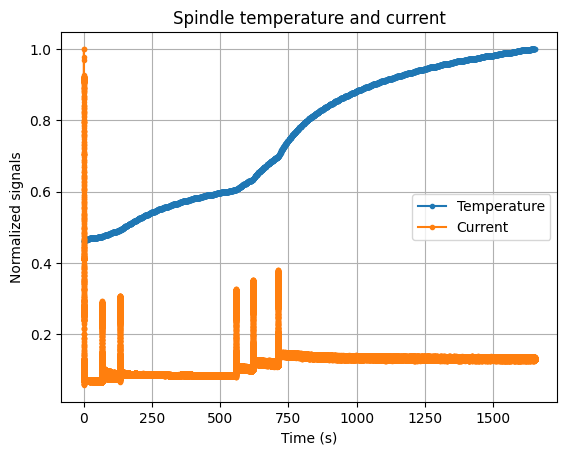

In [5]:
plt.plot(
    temperatureData.loc[:, "timeSeconds"], temperatureData.loc[:, "value"], "o-", markersize=3)
plt.plot(
    currentData.loc[:, "timeSeconds"], currentData.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
# plt.ylabel("Temperature (°C) / Current (A)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])

plt.title("Spindle temperature and current")
plt.grid()

plt.show()

## Compute average values for slots

For the two signals, we want to define a time interval, and compute the average for each successive intervals.

In [ ]:
def computeSlotsAverage(signal: pd.DataFrame, dt: float = 10) -> pd.DataFrame:
    """
    Compute the average of the signal in each slot.

    Parameters
    ----------
    signal (pd.DataFrame): The signal to process. It must have a "timeSeconds" column.
    dt (float, optional): The duration of each slot in seconds.

    Returns
    -------
    pd.DataFrame: A DataFrame with the average value of the signal in each slot.
    """
    signal["slot"] = signal["timeSeconds"] // dt
    return signal.groupby("slot").mean()


# test the function with basic data
data = pd.DataFrame({"timeSeconds": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                     "value": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

result = computeSlotsAverage(data, dt=2)
print(result)

      timeSeconds  value
slot                    
0             1.0    1.0
1             2.5    2.5
2             4.5    4.5
3             6.5    6.5
4             8.5    8.5
5            10.0   10.0


### Plot the data averaged by slots

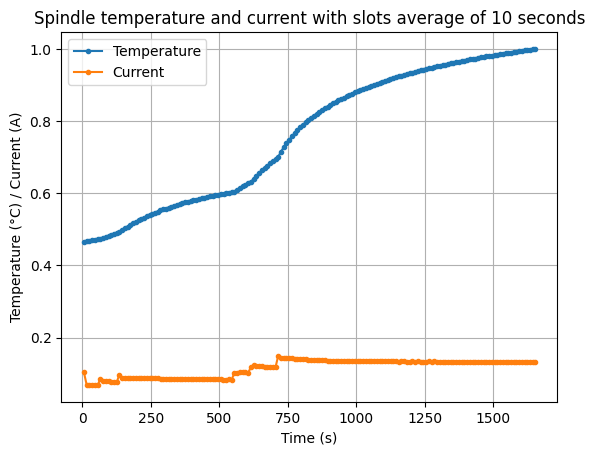

In [7]:
# apply the function to the temperature and current data
dt = 10 # seconds

temperatureSlots = computeSlotsAverage(temperatureData, dt)
currentSlots = computeSlotsAverage(currentData, dt)

# plot data versus time
plt.plot(
    temperatureSlots.loc[:, "timeSeconds"], temperatureSlots.loc[:, "value"], "o-", markersize=3)

plt.plot(
    currentSlots.loc[:, "timeSeconds"], currentSlots.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Current (A)")
plt.legend(["Temperature", "Current"])
plt.title("Spindle temperature and current with slots average of " + str(dt) + " seconds")
plt.grid()
plt.show()

### Plot the current versus temperature

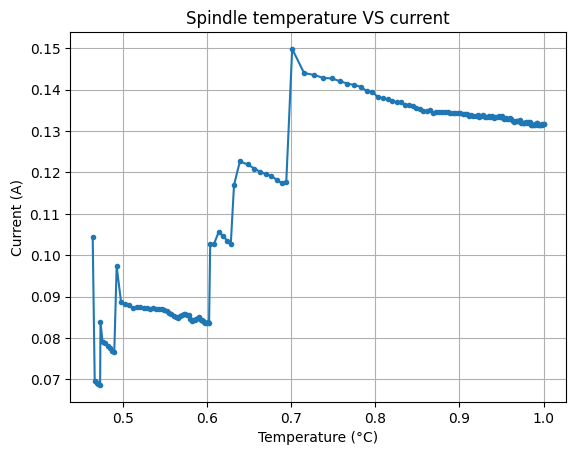

In [8]:
plt.plot(
    temperatureSlots.loc[:, "value"], currentSlots.loc[:, "value"], "-o", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Spindle temperature VS current")
plt.grid()
plt.show()

## Make a function to do all these steps

We want to plot the current VS temperature plot for multiple samples.

In [ ]:

def getCurrentAndTemp(samplePath: Path, timeSlot: float = 10, debug: bool = False) -> pd.DataFrame:
    """
    Get the current and temperature data from a sample path.

    Parameters
    ----------
    samplePath (str): The path to the sample.
    timeSlot (float): The duration of each slot on which to average in seconds.
        Defaults to 10 seconds.
    debug (bool, optional): Whether to print debug information. Defaults to True.

    Returns
    -------
    pd.DataFrame: The current and temperature data.
    """
    # load the data
    temperature = loadCsvSignal( os.path.join(samplePath, "lrSigSpindleTemp.csv"), debug=debug)
    current = loadCsvSignal(os.path.join(samplePath, "stSigAxCurrentS.csv"), debug=debug)

    temperatureSlots = computeSlotsAverage(temperature, timeSlot)
    currentSlots = computeSlotsAverage(current, timeSlot)

    # merge the data
    data = pd.DataFrame()
    data["timeSeconds"] = temperatureSlots["timeSeconds"]
    data["temperature"] = temperatureSlots["value"]
    data["current"] = currentSlots["value"]

    return data

## Test `getCurrentAndTemp` on various samples

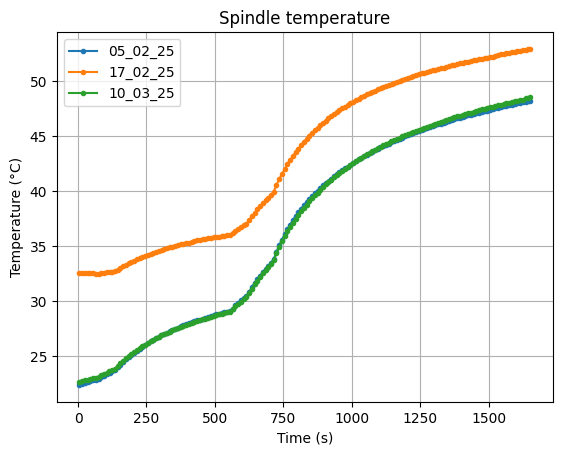

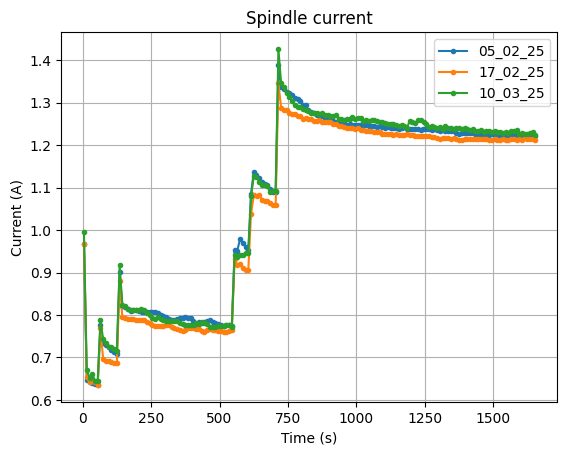

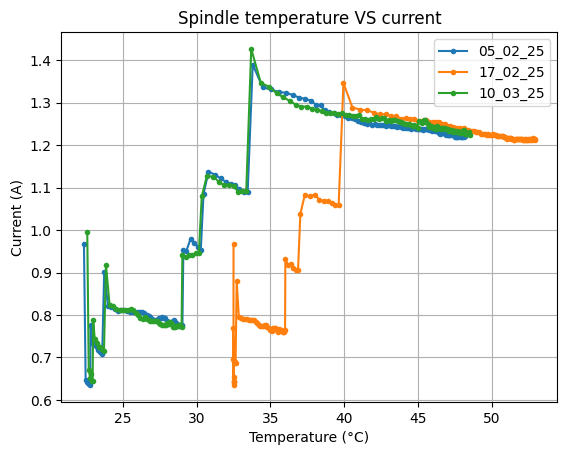

In [23]:
machinePath: Path = "../../data/Mecatis/"

samples: list[Path] = ["05_02_25", 
           "17_02_25",
           "10_03_25"] 

data = []
for sample in samples:
    path = os.path.join(machinePath, sample)
    data.append(getCurrentAndTemp(path))


def showTempCalibrationPlots(data: list, sampleNames: list) -> None:
    """
    Show the temperature and current plots for the given data.

    Parameters
    ----------
    data (list): The data to plot.
    """
    # plot temperature versus time
    plt.figure()
    for i in range(len(data)):
        plt.plot(
            data[i]["timeSeconds"], data[i]["temperature"], "o-", markersize=3, label=sampleNames[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.title("Spindle temperature")
    plt.legend()
    plt.grid()
    plt.show()

    # plot current versus time
    plt.figure()
    for i in range(len(data)):
        plt.plot(
            data[i]["timeSeconds"], data[i]["current"], "o-", markersize=3, label=sampleNames[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Current (A)")
    plt.title("Spindle current")
    plt.legend()
    plt.grid()
    plt.show()

    # plot current versus temperature
    plt.figure()
    for i in range(len(data)):
        plt.plot(
            data[i]["temperature"], data[i]["current"], "o-", markersize=3, label=sampleNames[i])
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Current (A)")
    plt.title("Spindle temperature VS current")
    plt.legend()
    plt.grid()
    plt.show()
        
showTempCalibrationPlots(data, samples)

## Finding optimal temperature offset 

We want to minimize the distance between a temperature signal and a reference using just an offset.

In [ ]:


def fun(x: float, data: pd.Series, reference: pd.Series) -> float:
    error = ((data - x - reference)**2).sum()/len(data) # mean square error (MSE)
    return error

def findTemperatureOffset(temperature: pd.Series, reference: pd.Series) -> float:
    """
    Find the temperature offset that minimizes the error between the temperature and reference.

    Parameters
    ----------
    temperature (pd.Series): The temperature data.
    reference (pd.Series): The reference data.

    Returns
    -------
    float: The temperature offset.
    """
    x0 = 0.0 # start with an offset of 0°C
    result = minimize(fun, x0, args=(temperature, reference))
    return result.x[0], np.sqrt(result.fun) # return the offset and the rmse

Test the function on some data:

In [25]:
offset1, error1 = findTemperatureOffset(data[1]["temperature"], data[0]["temperature"])

print("sample 1: ", samples[1])
print("Offset: ", offset1.round(2), "°C")
print("RMSE: ", error1.round(2), "°C")

offset2, error2 = findTemperatureOffset(data[2]["temperature"], data[0]["temperature"])
print("sample 2: ", samples[2])
print("Offset: ", offset2.round(2), "°C")
print("RMSE: ", error2.round(2), "°C")


sample 1:  17_02_25
Offset:  6.35 °C
RMSE:  1.47 °C
sample 2:  10_03_25
Offset:  0.04 °C
RMSE:  0.14 °C


Plot the corrected data

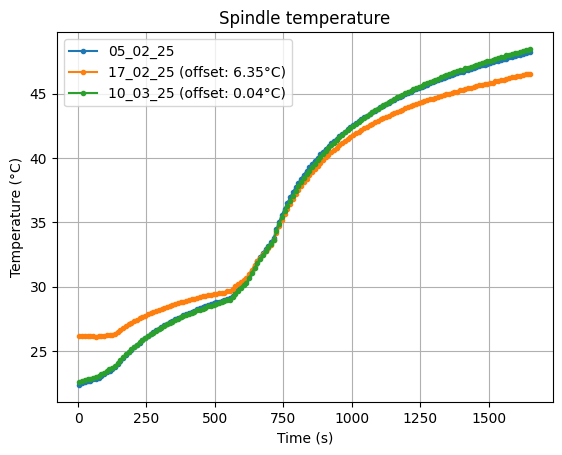

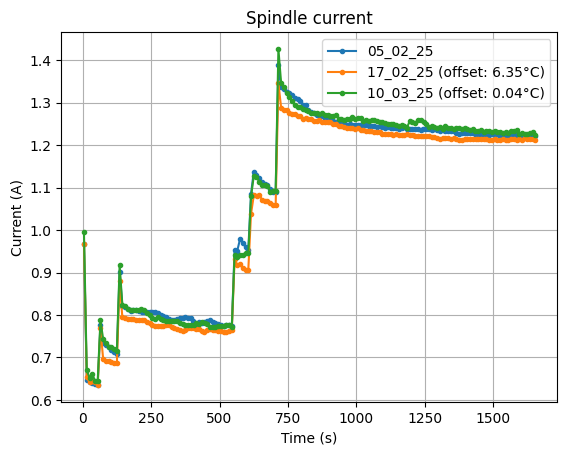

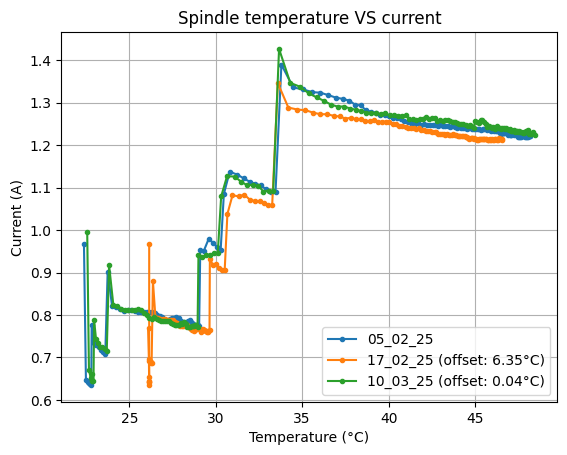

In [26]:
data[1]["temperature"] = data[1]["temperature"] - offset1
samples[1] = samples[1] + " (offset: " + str(offset1.round(2)) + "°C)"

data[2]["temperature"] = data[2]["temperature"] - offset2
samples[2] = samples[2] + " (offset: " + str(offset2.round(2)) + "°C)"

showTempCalibrationPlots(data, samples)

## Split each signal into segments
We want to split all the signals into segments and process each of the segments independently. First we need to find the start and end indices of the segments.

In [ ]:
from utils.detectConstantSegments import detectConstantSegments

dataPath: Path = "../../data/normalized-2025_04_08/"

sampleName = "Mecatis_05_02_25.parquet"

data = pd.read_parquet(os.path.join(dataPath, sampleName))

print(data.shape)

time = data["timeSeconds"]
command = data["stSigSpindleVelocity"]

segmentIndices = detectConstantSegments(time, command)

print(segmentIndices)


(2065466, 75)
[(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]


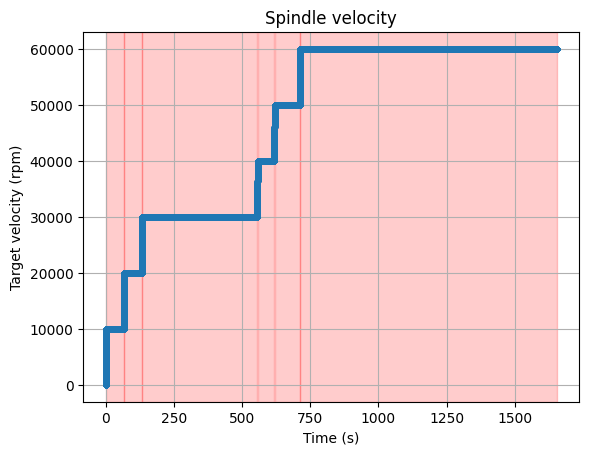

In [6]:
# plot the data
plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Target velocity (rpm)")
plt.title("Spindle velocity")
plt.grid()
for segment in segmentIndices:
    plt.axvspan(time[segment[0]], time[segment[1]], color="red", alpha=0.2)
plt.show()

## Cut a signal into the segments and plot all the segments versus time

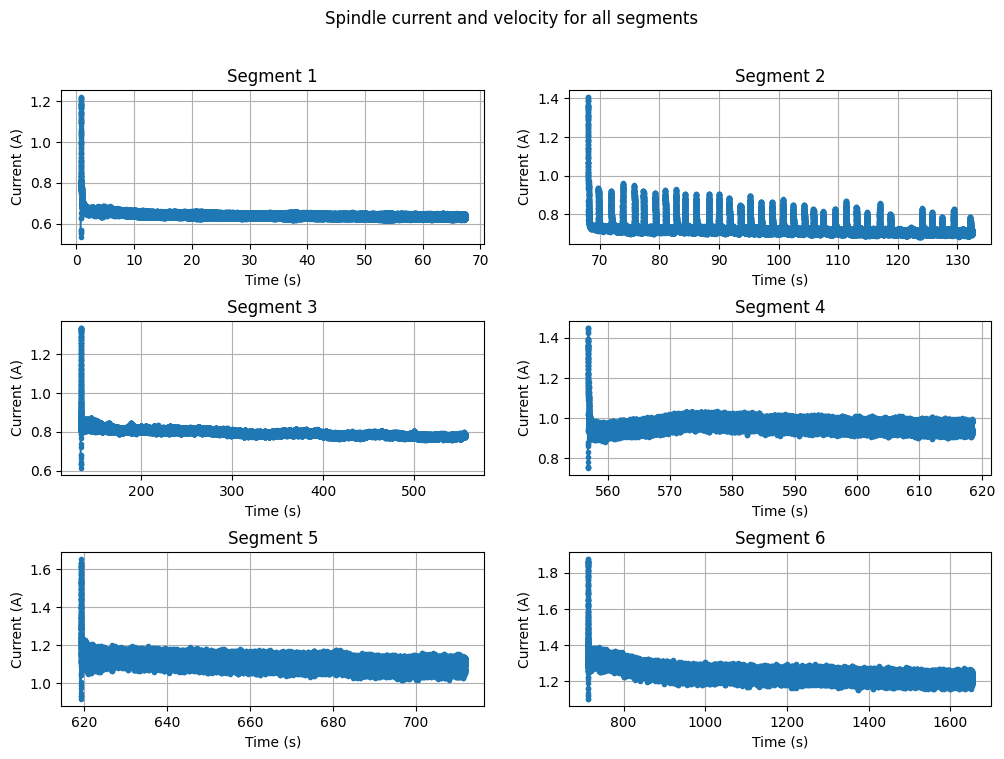

In [15]:
spindleCurrent = data["stSigAxCurrentS"]

# plot all the data using suplots

nbColumns = 2
nbRows = 3

fig, axs = plt.subplots(nbRows, nbColumns, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Spindle current and velocity for all segments")

# plot each segment
for i in range(len(segmentIndices)):
    segment = segmentIndices[i]
    start = segment[0]
    end = segment[1]
    
    segmentTime = time[start:end]
    segmentCurrent = spindleCurrent[start:end]

    colIndex = i % nbColumns
    rowIndex = i // nbColumns

    axs[rowIndex, colIndex].plot(segmentTime, segmentCurrent, "o-", markersize=3)
    axs[rowIndex, colIndex].set_xlabel("Time (s)")
    axs[rowIndex, colIndex].set_ylabel("Current (A)")
    axs[rowIndex, colIndex].set_title("Segment " + str(i+1))
    axs[rowIndex, colIndex].grid()

plt.show()